# 用户价值预测
* 根据各个参数预测用户的价值

[kggle链接](https://www.kaggle.com/c/santander-value-prediction-challenge)

In [1]:
# 导入库
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

##  先载入数据

In [2]:
DATAPATH="D:/dataset/SVPC/"
train_df = pd.read_csv(DATAPATH+"train.csv")
test_df = pd.read_csv(DATAPATH+"test.csv")
print("Train rows and columns : ", train_df.shape)
print("Test rows and columns : ", test_df.shape)

Train rows and columns :  (4459, 4993)
Test rows and columns :  (49342, 4992)


可以看到训练集与测试集大概是1:10的关系.
看下大概长得怎么样

In [3]:
train_df.head(5)

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


第一列是用户id,第二列是要预测的用户价值,剩下的4991列是各个指标,不过是匿名的.
大部分都为零


我们将根据这些指标预测用户价值.

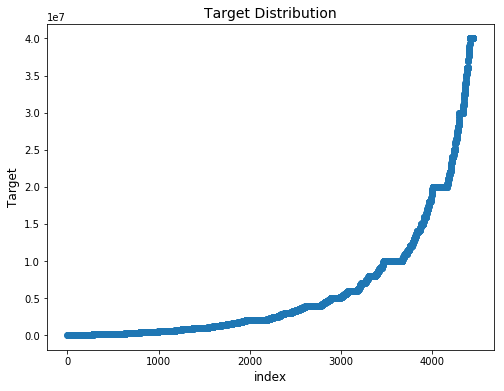

In [3]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()

C:\anaconda\envs\kaggle180629\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


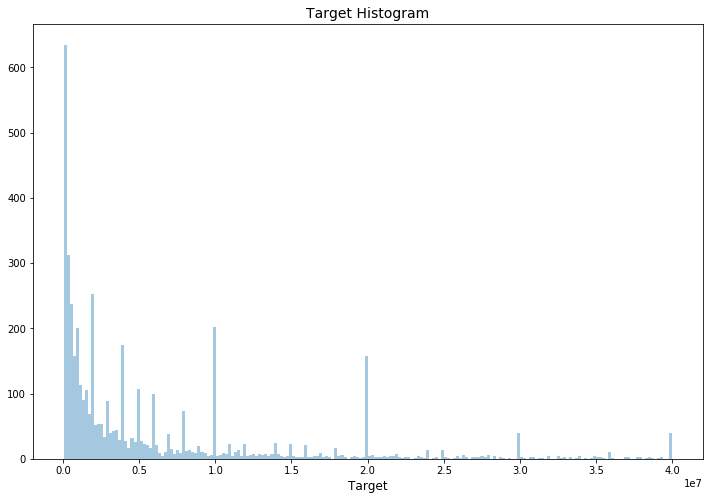

In [4]:
plt.figure(figsize=(12,8))
sns.distplot(train_df["target"].values, bins=200, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Target Histogram", fontsize=14)
plt.show()

C:\anaconda\envs\kaggle180629\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


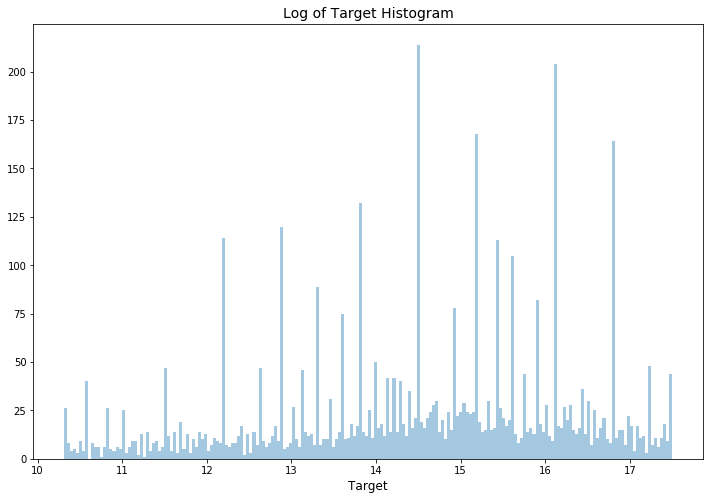

In [5]:
plt.figure(figsize=(12,8))
sns.distplot( np.log1p(train_df["target"].values), bins=200, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Log of Target Histogram", fontsize=14)
plt.show()

In [6]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


In [7]:
missing_df = test_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


In [8]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


In [3]:
unique_df = train_df.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
constant_df = unique_df[unique_df["unique_count"]==1]
constant_df.shape

(256, 2)

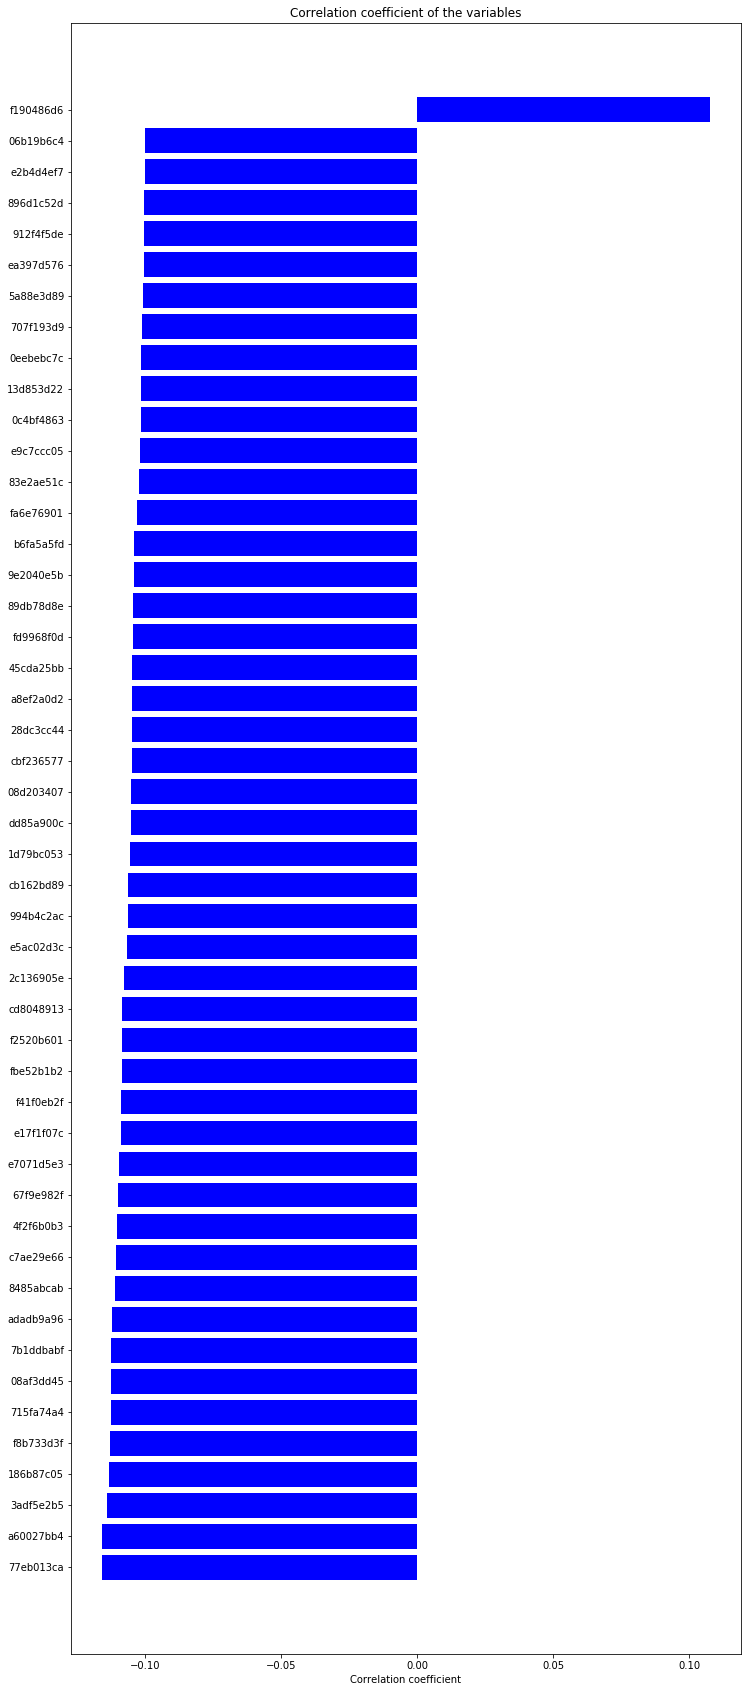

In [10]:
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings("ignore")

labels = []
values = []

for col in train_df.columns:
    if col not in ["ID", "target"]:
        labels.append(col)
        values.append(spearmanr(train_df[col].values, train_df["target"].values)[0])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
 
corr_df = corr_df[(corr_df['corr_values']>0.1) | (corr_df['corr_values']<-0.1)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,30))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

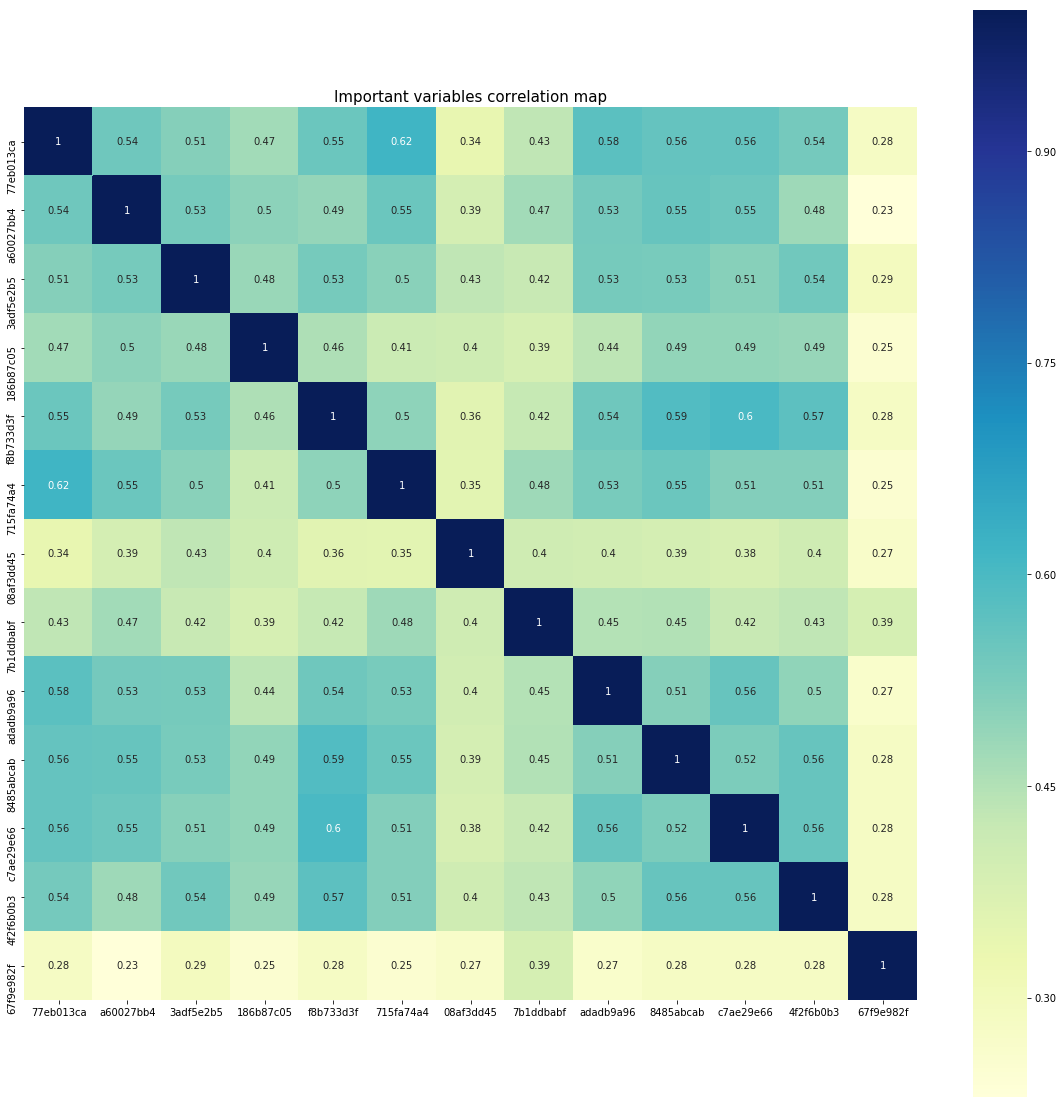

In [11]:
cols_to_use = corr_df[(corr_df['corr_values']>0.11) | (corr_df['corr_values']<-0.11)].col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

In [8]:
### Get the X and y variables for building model ###
train_X = train_df.drop(constant_df.col_name.tolist() + ["ID", "target"], axis=1)
test_X = test_df.drop(constant_df.col_name.tolist() + ["ID"], axis=1)
train_y =np.log1p(train_df["target"].values)

In [9]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plot the importances ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()


KeyboardInterrupt: 

In [10]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 2000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [11]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.43679
[400]	valid_0's rmse: 1.41936
Early stopping, best iteration is:
[313]	valid_0's rmse: 1.41841
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.42911
[400]	valid_0's rmse: 1.39647
Early stopping, best iteration is:
[418]	valid_0's rmse: 1.39599
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.43516
[400]	valid_0's rmse: 1.41068
Early stopping, best iteration is:
[413]	valid_0's rmse: 1.41017
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.48048
[400]	valid_0's rmse: 1.44501
[600]	valid_0's rmse: 1.43852
[800]	valid_0's rmse: 1.43693
Early stopping, best iteration is:
[724]	valid_0's rmse: 1.43632
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.47301
[400]	valid_0's rmse: 1.45493
Early stopping, best iteration is:
[390]	valid_0's rmse: 1.45456


In [13]:

sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = pred_test_full
sub_df.to_csv("baseline_lgb2.csv", index=False)

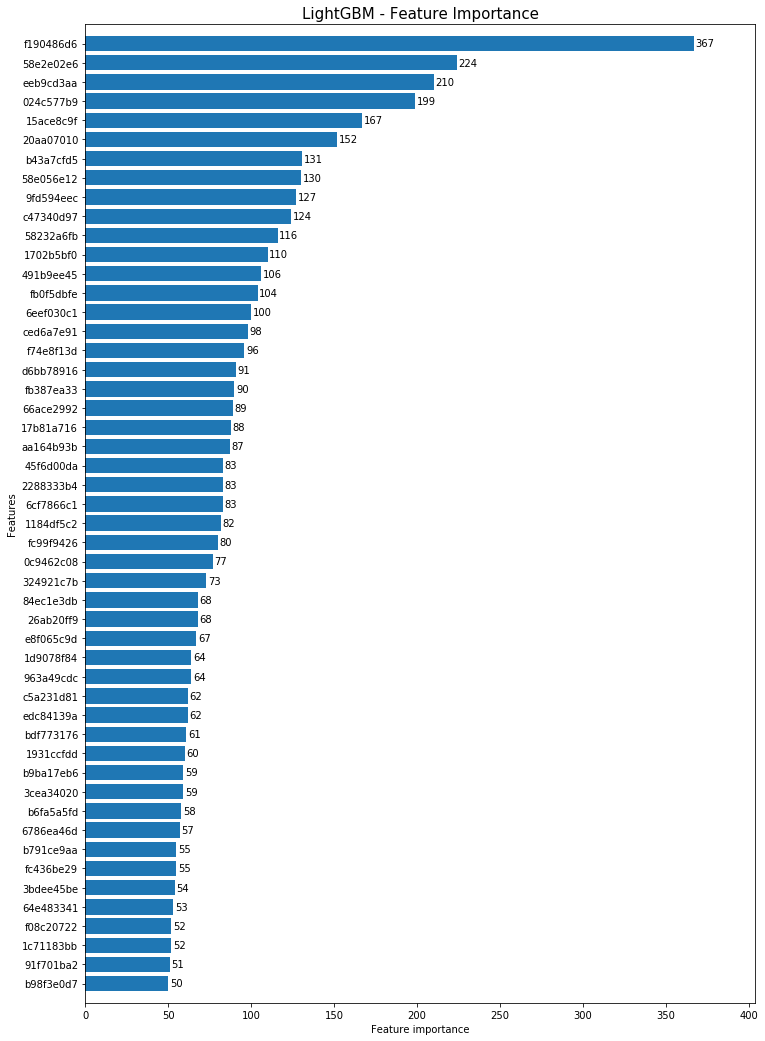

In [17]:
### Feature Importance ###
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [18]:
### for me
train_df.target.mean()

5944923.322036331

In [19]:
p=pd.DataFrame({"id":train_df["ID"],"target":train_df.target.mean()})

In [20]:
p.head()

,id,target
0,000d6aaf2,5.944923e+06
1,000fbd867,5.944923e+06
2,0027d6b71,5.944923e+06
3,0028cbf45,5.944923e+06
4,002a68644,5.944923e+06


In [21]:

np.sqrt(((np.log(p["target"]+1)-np.log(train_df.target+1))**2).mean())

2.0718031227318754

In [22]:
def thermse(num):
    p=pd.DataFrame({"id":train_df["ID"],"target":num})
    return np.sqrt(((np.log(p["target"]+1)-np.log(train_df.target+1))**2).mean())

In [23]:
data=[]
for i in range(620,640,1):
    data.append([i,thermse(10**(i/100.0))])
data

[[620, 1.763806577429181],
 [621, 1.7611584405876726],
 [622, 1.7588077897579628],
 [623, 1.756755819119444],
 [624, 1.7550035763465934],
 [625, 1.7535519599646159],
 [626, 1.7524017170650326],
 [627, 1.751553441394647],
 [628, 1.7510075718292222],
 [629, 1.750764391240985],
 [630, 1.750824025766757],
 [631, 1.7511864444811251],
 [632, 1.7518514594766221],
 [633, 1.7528187263504356],
 [634, 1.7540877450947066],
 [635, 1.755657861385059],
 [636, 1.7575282682596391],
 [637, 1.7596980081786595],
 [638, 1.7621659754522756],
 [639, 1.7649309190225724]]

In [24]:
p=pd.DataFrame({"ID":test_df["ID"],"target":1995262})
# p.to_csv("rmse.csv", index=False)

## 神经网络回归预测

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [51]:
X = train_X.values
Y = train_y
T = test_X.values

In [27]:
X.shape

(4459, 4735)

In [28]:
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], init='normal', activation='relu'))
model.add(Dense(256, init='normal', activation='softplus'))
model.add(Dropout(0.1))
model.add(Dense(1, init='normal',activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [29]:
seed = 521
np.random.seed(seed)

In [30]:
model.summary()
#model.fit(X,Y,batch_size=X.shape[1],epochs=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                151552    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 160,257
Trainable params: 160,257
Non-trainable params: 0
_________________________________________________________________


In [31]:
# p=pd.DataFrame({"ID":test_df["ID"],"target":model.predict(T).reshape(T.shape[0])})
# p.to_csv("nn2l.csv", index=False)

## sklearn
简单提升

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
rng = np.random.RandomState(1)
clf = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5),n_estimators=1000,loss='exponential',random_state=rng)
clf=clf.fit(X,Y)

In [60]:
Y,T

(array([38000000.,   600000., 10000000., ...,  2800000., 10000000.,
        20000000.]), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [55]:
sub=clf.predict(T)

In [59]:
sub[0:100]

array([16415182.09925521, 16463701.95655517, 16463701.95655517,
       16774854.17008197, 16463701.95655517, 16463701.95655517,
       16463701.95655517, 16463701.95655517, 16463701.95655517,
       16223183.95339847, 16433857.66326793, 16463701.95655517,
       16415182.09925521, 16463701.95655517, 16463701.95655517,
       16323215.05212414, 16415182.09925521, 16345568.82577349,
       16463701.95655517, 16684014.79385051, 16463701.95655517,
       16463701.95655517, 16463701.95655517, 16463701.95655517,
       16433857.66326793, 16463701.95655517, 16463701.95655517,
       16415182.09925521, 16690483.34763543, 16463701.95655517,
       16463701.95655517, 16433857.66326793, 16463701.95655517,
       16264801.03248916, 16474625.6615131 , 16345568.82577349,
       16463701.95655517, 16463701.95655517, 16463701.95655517,
       16463701.95655517, 16264801.03248916, 16463701.95655517,
       16400525.69834043, 16264801.03248916, 16463701.95655517,
       16345568.82577349, 16433857.66326